In [1]:
#@title Imports. { vertical-output: true }

import os

from matplotlib import pyplot as plt
import numpy as np

from perch_hoplite.agile import audio_loader
from perch_hoplite.agile import classifier
from perch_hoplite.agile import classifier_data
from perch_hoplite.agile import embedding_display
from perch_hoplite.agile import source_info
from perch_hoplite.db  import brutalism
from perch_hoplite.db import score_functions
from perch_hoplite.db  import search_results
from perch_hoplite.db import sqlite_usearch_impl
from perch_hoplite.zoo import model_configs


2025-05-15 16:50:38.609906: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747327838.630726  109768 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747327838.636726  109768 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747327838.655681  109768 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747327838.655701  109768 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747327838.655703  109768 computation_placer.cc:177] computation placer alr

In [2]:
#@title Load model and connect to database. { vertical-output: true }

#@markdown Location of database containing audio embeddings.
db_path = '/home/Sedlar/data' #'/home/Sedlar/data/INCT17'  #@param {type:'string'}
#@markdown Identifier (eg, name) to attach to labels produced during validation.
annotator_id = 'joseph'  #@param {type:'string'}

db = sqlite_usearch_impl.SQLiteUsearchDB.create(db_path)
db_model_config = db.get_metadata('model_config')
embed_config = db.get_metadata('audio_sources')
model_class = model_configs.get_model_class(db_model_config.model_key)
embedding_model = model_class.from_config(db_model_config.model_config)
audio_sources = source_info.AudioSources.from_config_dict(embed_config)
if hasattr(embedding_model, 'window_size_s'):
  window_size_s = embedding_model.window_size_s
else:
  window_size_s = 5.0
audio_filepath_loader = audio_loader.make_filepath_loader(
    audio_sources=audio_sources,
    window_size_s=window_size_s,
    sample_rate_hz=embedding_model.sample_rate,
)

W0000 00:00:1747327845.965397  109768 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# Search

In [3]:
#@title Load query audio. { vertical-output: true }

#@markdown The `query_uri` can be a URL, filepath, or Xeno-Canto ID
#@markdown (like `xc777802`, containing an Eastern Whipbird (`easwhi1`)).
query_uri = '/home/Sedlar/data/INCT17/INCT17_20201129_030000_38_41.wav'  #@param {type:'string'}
query_label = 'jastest'  #@param {type:'string'}

query = embedding_display.QueryDisplay(
    uri=query_uri, offset_s=0.0, window_size_s=5.0, sample_rate_hz=32000)
_ = query.display_interactive()

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='offset_s', max=3.0), Output…

In [4]:
#@title Embed the Query and Search. { vertical-output: true }

#@markdown Number of results to find and display.
num_results = 50  #@param
query_embedding = embedding_model.embed(
    query.get_audio_window()).embeddings[0, 0]

#@markdown If checked, search for examples
#@markdown near a particular target score.
target_sampling = False  #@param {type: 'boolean'}

#@markdown When target sampling, target this score.
target_score = -1.0  #@param
if not target_sampling:
  target_score = None

#@markdown If True, search the full DB. Otherwise, use approximate
#@markdown nearest-neighbor search.
exact_search = False  #@param {type: 'boolean'}

if exact_search:
  score_fn = score_functions.get_score_fn('dot', target_score=target_score)
  results, all_scores = brutalism.threaded_brute_search(
      db, query_embedding, num_results, score_fn=score_fn)
  # TODO(tomdenton): Better histogram when target sampling.
  _ = plt.hist(all_scores, bins=100)
  hit_scores = [r.sort_score for r in results.search_results]
  plt.scatter(hit_scores, np.zeros_like(hit_scores), marker='|',
              color='r', alpha=0.5)
else:
  ann_matches = db.ui.search(query_embedding, count=num_results)
  results = search_results.TopKSearchResults(top_k=num_results)
  for k, d in zip(ann_matches.keys, ann_matches.distances):
    results.update(search_results.SearchResult(k, d))


I0000 00:00:1747327866.854413  109768 service.cc:152] XLA service 0x59991fb260a0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747327866.854490  109768 service.cc:160]   StreamExecutor device (0): Host, Default Version
2025-05-15 16:51:07.116764: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-15 16:51:07.131930: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator jax2tf_infer_fn_/assert_equal_1/Assert/AssertGuard/Assert
I0000 00:00:1747327869.185859  109768 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Page 1 of 6
--------------------------------------------------------------------------------



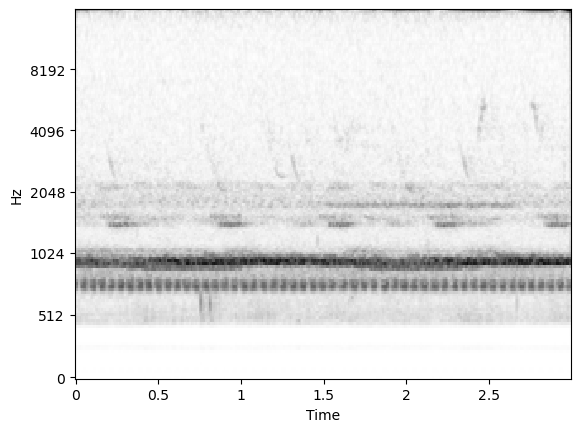

dataset name : anuraset
source uri   : audio/INCT17/INCT17_20201129_030000_51_54.wav
offset_s     : 0.00
score        : -5.65


GridspecLayout(children=(Button(description='jastest', layout=Layout(grid_area='widget001'), style=ButtonStyle…


--------------------------------------------------------------------------------


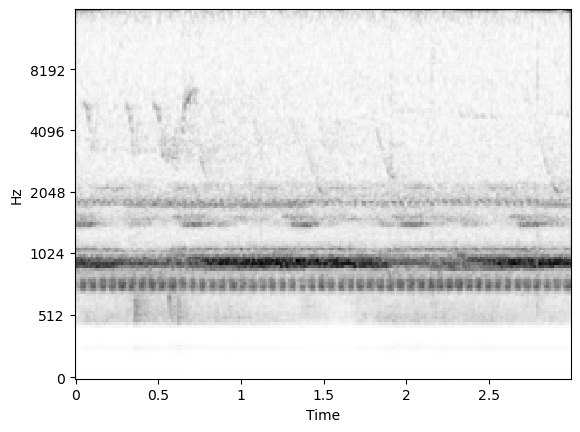

dataset name : anuraset
source uri   : audio/INCT17/INCT17_20201129_030000_0_3.wav
offset_s     : 0.00
rank         : 1
score        : -5.66


GridspecLayout(children=(Button(description='jastest', layout=Layout(grid_area='widget001'), style=ButtonStyle…


--------------------------------------------------------------------------------


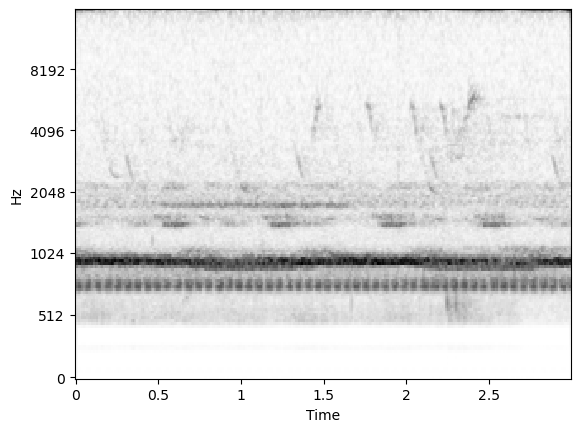

dataset name : anuraset
source uri   : audio/INCT17/INCT17_20201129_030000_52_55.wav
offset_s     : 0.00
rank         : 2
score        : -5.74


GridspecLayout(children=(Button(description='jastest', layout=Layout(grid_area='widget001'), style=ButtonStyle…


--------------------------------------------------------------------------------


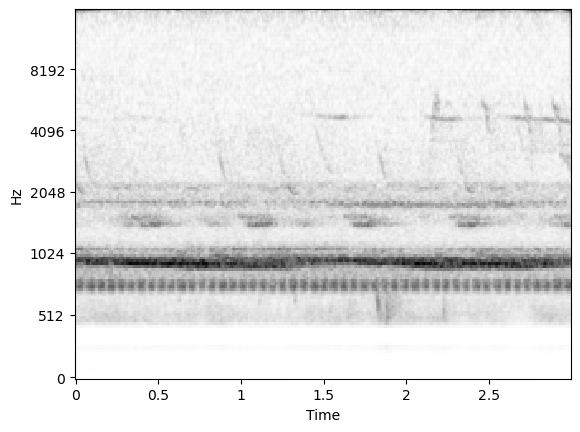

dataset name : anuraset
source uri   : audio/INCT17/INCT17_20201129_030000_22_25.wav
offset_s     : 0.00
rank         : 3
score        : -5.74


GridspecLayout(children=(Button(description='jastest', layout=Layout(grid_area='widget001'), style=ButtonStyle…


--------------------------------------------------------------------------------


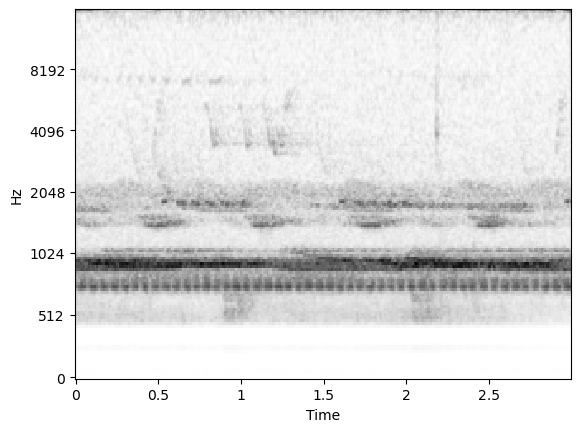

dataset name : anuraset
source uri   : audio/INCT17/INCT17_20201129_020000_26_29.wav
offset_s     : 0.00
rank         : 4
score        : -5.75


GridspecLayout(children=(Button(description='jastest', layout=Layout(grid_area='widget001'), style=ButtonStyle…


--------------------------------------------------------------------------------


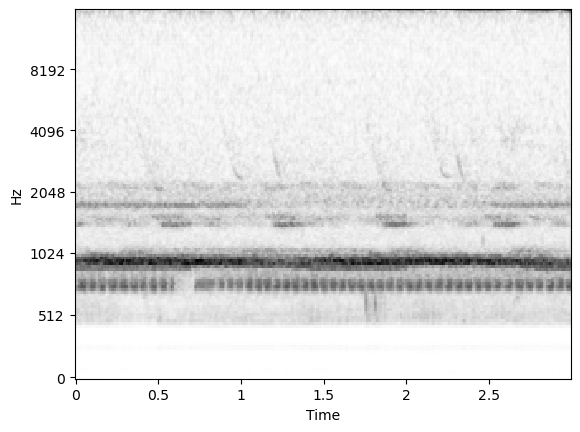

dataset name : anuraset
source uri   : audio/INCT17/INCT17_20201129_030000_50_53.wav
offset_s     : 0.00
rank         : 5
score        : -5.87


GridspecLayout(children=(Button(description='jastest', layout=Layout(grid_area='widget001'), style=ButtonStyle…


--------------------------------------------------------------------------------


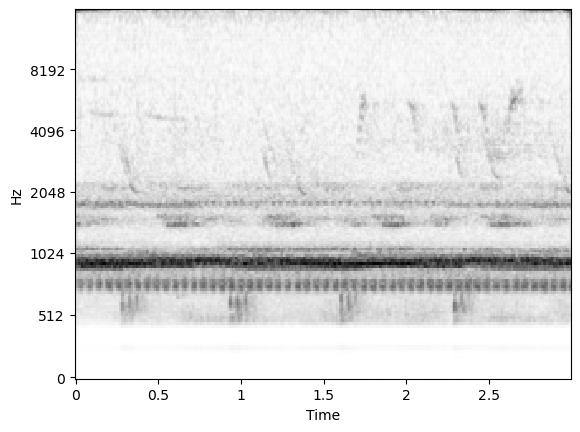

dataset name : anuraset
source uri   : audio/INCT17/INCT17_20201129_030000_16_19.wav
offset_s     : 0.00
rank         : 6
score        : -5.88


GridspecLayout(children=(Button(description='jastest', layout=Layout(grid_area='widget001'), style=ButtonStyle…


--------------------------------------------------------------------------------


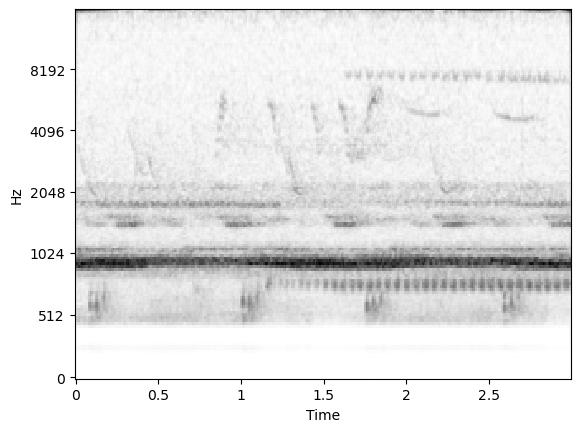

dataset name : anuraset
source uri   : audio/INCT17/INCT17_20201129_030000_13_16.wav
offset_s     : 0.00
rank         : 7
score        : -6.02


GridspecLayout(children=(Button(description='jastest', layout=Layout(grid_area='widget001'), style=ButtonStyle…


--------------------------------------------------------------------------------


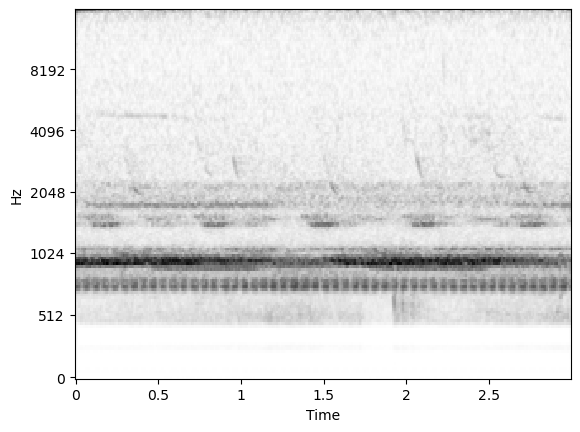

dataset name : anuraset
source uri   : audio/INCT17/INCT17_20201129_030000_55_58.wav
offset_s     : 0.00
rank         : 8
score        : -6.02


GridspecLayout(children=(Button(description='jastest', layout=Layout(grid_area='widget001'), style=ButtonStyle…


--------------------------------------------------------------------------------


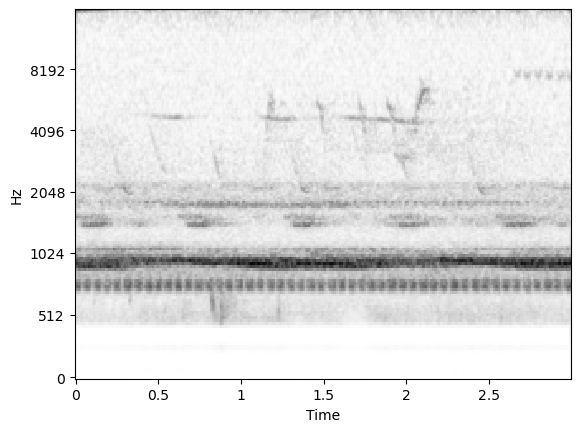

dataset name : anuraset
source uri   : audio/INCT17/INCT17_20201129_030000_23_26.wav
offset_s     : 0.00
rank         : 9
score        : -6.03


GridspecLayout(children=(Button(description='jastest', layout=Layout(grid_area='widget001'), style=ButtonStyle…


--------------------------------------------------------------------------------
Page 1 of 6


Button(description='Prev Page', style=ButtonStyle())

Button(description='Next Page', style=ButtonStyle())

In [5]:
#@title Display Results. { vertical-output: true }

display_results = embedding_display.EmbeddingDisplayGroup.from_search_results(
    results, db, sample_rate_hz=32000, frame_rate=100,
    audio_loader=audio_filepath_loader)
display_results.display(positive_labels=[query_label])

In [6]:
#@title Save data labels. { vertical-output: true }

prev_lbls, new_lbls = 0, 0
for lbl in display_results.harvest_labels(annotator_id):
  check = db.insert_label(lbl, skip_duplicates=True)
  new_lbls += check
  prev_lbls += (1 - check)
print('\nnew_lbls: ', new_lbls)
print('\nprev_lbls: ', prev_lbls)


new_lbls:  0

prev_lbls:  0


# Classify

In [7]:
#@title Classifier training. { vertical-output: true }

#@markdown Set of labels to classify. If None, auto-populated from the DB.
target_labels = None  #@param

#@markdown Classifier traning hyperparams. These should not require tuning.
learning_rate = 1e-3  #@param
weak_neg_weight = 0.05  #@param
l2_mu = 0.000  #@param
num_steps = 128  #@param

train_ratio = 0.9  #@param
batch_size = 128  #@param
weak_negatives_batch_size = 128  #@param
loss_fn_name = 'bce'  #@param ['hinge', 'bce']

data_manager = classifier_data.AgileDataManager(
    target_labels=target_labels,
    db=db,
    train_ratio=train_ratio,
    min_eval_examples=1,
    batch_size=batch_size,
    weak_negatives_batch_size=weak_negatives_batch_size,
    rng=np.random.default_rng(seed=5))
print('Training for target labels : ')
print(data_manager.get_target_labels())
linear_classifier, eval_scores = classifier.train_linear_classifier(
    data_manager=data_manager,
    learning_rate=learning_rate,
    weak_neg_weight=weak_neg_weight,
    num_train_steps=num_steps,
)
print('\n' + '-' * 80)
top1 = eval_scores['top1_acc']
print(f'top-1      {top1:.3f}')
rocauc = eval_scores['roc_auc']
print(f'roc_auc    {rocauc:.3f}')
cmap = eval_scores['cmap']
print(f'cmap       {cmap:.3f}')

# Save linear classifier.
linear_classifier.save(os.path.join(db_path, 'agile_classifier_v2.pt'))

Training for target labels : 
('SPHSUR',)


  0%|          | 0/128 [00:00<?, ?it/s]

Loss 0.03668357:  78%|███████▊  | 100/128 [00:03<00:01, 27.95it/s]


--------------------------------------------------------------------------------
top-1      1.000
roc_auc    nan
cmap       1.000



/home/Sedlar/miniforge3/envs/hoplite/lib/python3.10/site-packages/perch_hoplite/agile/metrics.py:205: RuntimeWarning: Mean of empty slice.
  gmr = num_p_above.mean(axis=-1, where=(labels == 0) & label_mask) / num_p
/home/Sedlar/miniforge3/envs/hoplite/lib/python3.10/site-packages/numpy/_core/_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/Sedlar/miniforge3/envs/hoplite/lib/python3.10/site-packages/perch_hoplite/agile/metrics.py:206: RuntimeWarning: invalid value encountered in divide
  gmr_var = (num_n_above / num_n[:, None]).var(


In [8]:
data_manager.get_target_labels()

('SPHSUR',)

In [10]:
len(data_manager.get_target_labels())

1

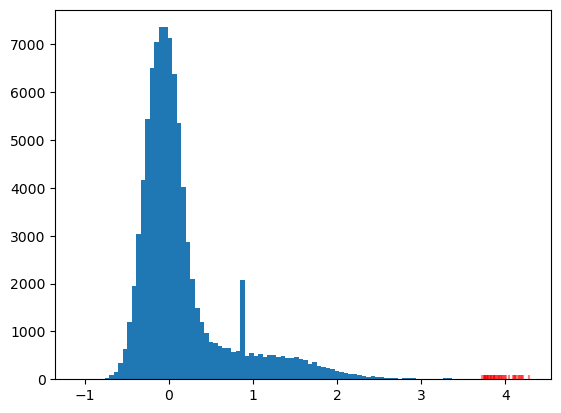

In [11]:
#@title Review Classifier Results. { vertical-output: true }

#@markdown Number of results to find and display.
target_label = 'SPHSUR' #'easwhi1'  #@param {type:'string'}
num_results = 50  #@param

target_label_idx = data_manager.get_target_labels().index(target_label)
class_query = linear_classifier.beta[:, target_label_idx]
bias = linear_classifier.beta_bias[target_label_idx]

#@markdown Number of (randomly selected) database entries to search over.
sample_size = 1_000_000  #@param

#@markdown Whether to use margin-sampling. If checked, search for examples
#@markdown with logits near a particular target score (usually 0).
margin_sampling = False  #@param {type: 'boolean'}

#@markdown When margin sampling, target this logit.
margin_target_score = -0.0  #@param
if not margin_sampling:
  margin_target_score = None
score_fn = score_functions.get_score_fn(
    'dot', bias=bias, target_score=margin_target_score)
results, all_scores = brutalism.threaded_brute_search(
    db, class_query, num_results, score_fn=score_fn,
    sample_size=sample_size)

# TODO(tomdenton): Better histogram when margin sampling.
_ = plt.hist(all_scores, bins=100)
hit_scores = [r.sort_score for r in results.search_results]
plt.scatter(hit_scores, np.zeros_like(hit_scores), marker='|',
            color='r', alpha=0.5)


Page 1 of 6
--------------------------------------------------------------------------------



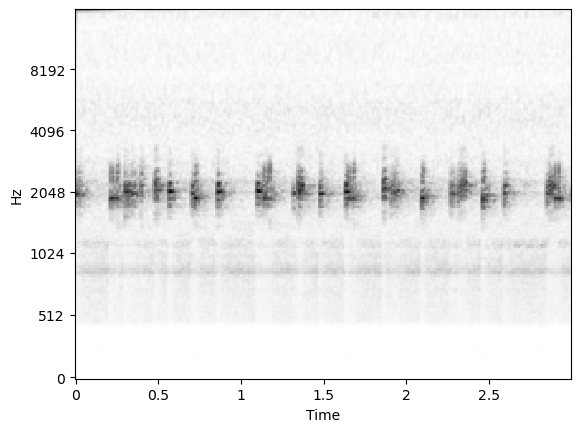

dataset name : anuraset
source uri   : audio/INCT20955/INCT20955_20200327_191500_10_13.wav
offset_s     : 0.00
score        : 4.28


GridspecLayout(children=(Button(description='SPHSUR', layout=Layout(grid_area='widget001'), style=ButtonStyle(…


--------------------------------------------------------------------------------


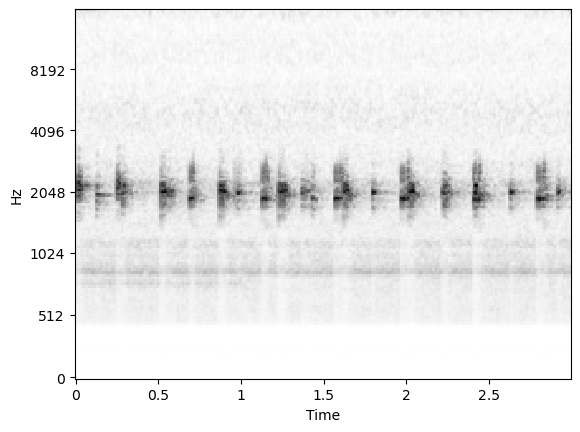

dataset name : anuraset
source uri   : audio/INCT20955/INCT20955_20200327_191500_50_53.wav
offset_s     : 0.00
rank         : 1
score        : 4.21


GridspecLayout(children=(Button(description='SPHSUR', layout=Layout(grid_area='widget001'), style=ButtonStyle(…


--------------------------------------------------------------------------------


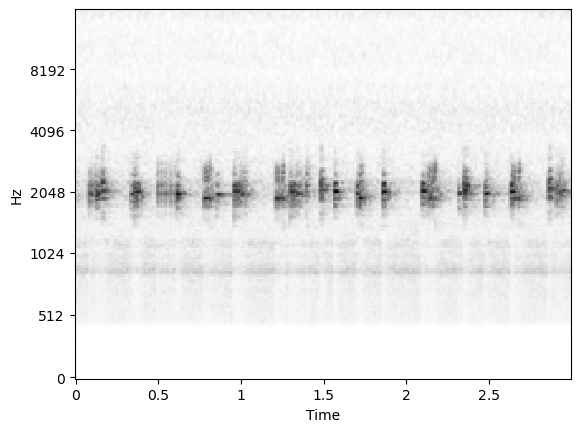

dataset name : anuraset
source uri   : audio/INCT20955/INCT20955_20200327_191500_9_12.wav
offset_s     : 0.00
rank         : 2
score        : 4.20


GridspecLayout(children=(Button(description='SPHSUR', layout=Layout(grid_area='widget001'), style=ButtonStyle(…


--------------------------------------------------------------------------------


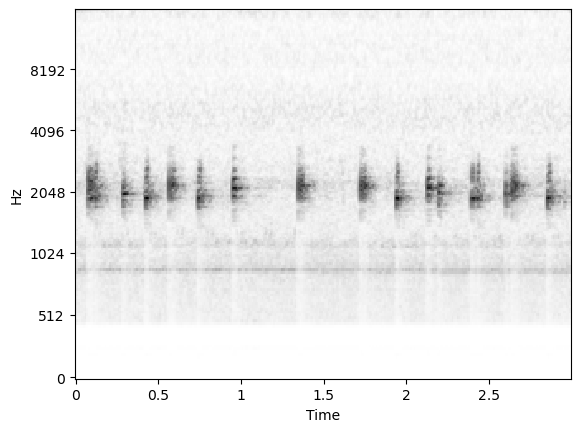

dataset name : anuraset
source uri   : audio/INCT20955/INCT20955_20200327_191500_31_34.wav
offset_s     : 0.00
rank         : 3
score        : 4.19


GridspecLayout(children=(Button(description='SPHSUR', layout=Layout(grid_area='widget001'), style=ButtonStyle(…


--------------------------------------------------------------------------------


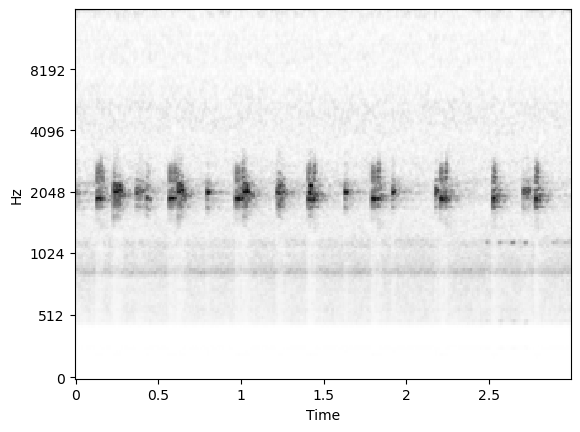

dataset name : anuraset
source uri   : audio/INCT20955/INCT20955_20200327_191500_51_54.wav
offset_s     : 0.00
rank         : 4
score        : 4.18


GridspecLayout(children=(Button(description='SPHSUR', layout=Layout(grid_area='widget001'), style=ButtonStyle(…


--------------------------------------------------------------------------------


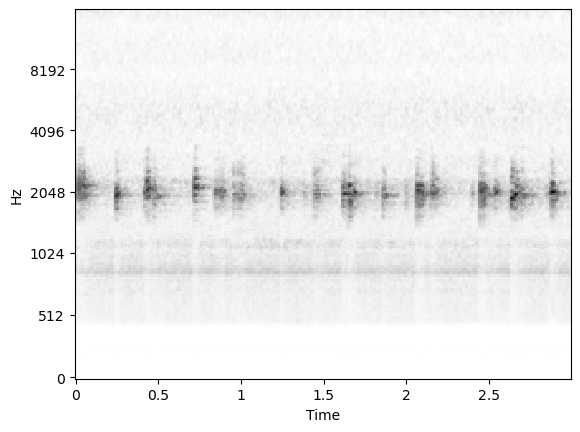

dataset name : anuraset
source uri   : audio/INCT20955/INCT20955_20200327_191500_0_3.wav
offset_s     : 0.00
rank         : 5
score        : 4.16


GridspecLayout(children=(Button(description='SPHSUR', layout=Layout(grid_area='widget001'), style=ButtonStyle(…


--------------------------------------------------------------------------------


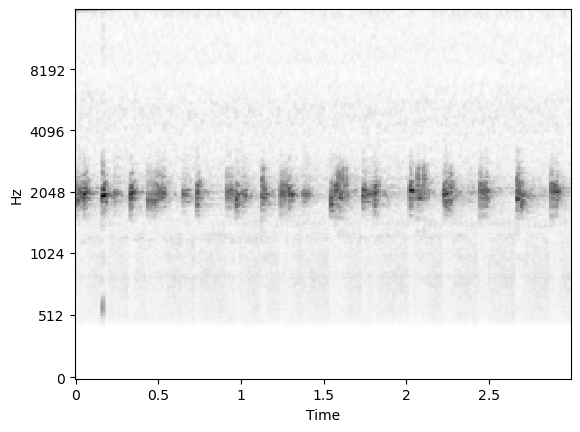

dataset name : anuraset
source uri   : audio/INCT20955/INCT20955_20200325_193000_3_6.wav
offset_s     : 0.00
rank         : 6
score        : 4.16


GridspecLayout(children=(Button(description='SPHSUR', layout=Layout(grid_area='widget001'), style=ButtonStyle(…


--------------------------------------------------------------------------------


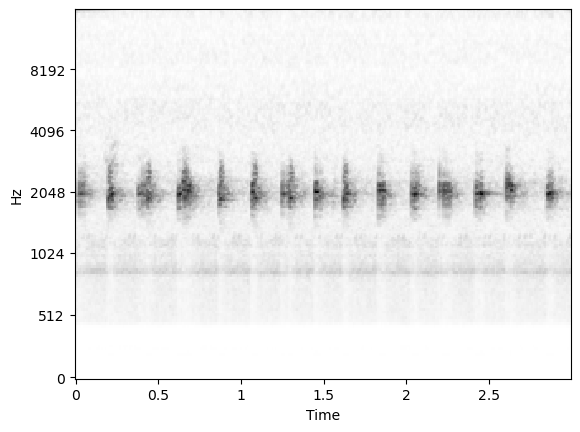

dataset name : anuraset
source uri   : audio/INCT20955/INCT20955_20200327_191500_37_40.wav
offset_s     : 0.00
rank         : 7
score        : 4.12


GridspecLayout(children=(Button(description='SPHSUR', layout=Layout(grid_area='widget001'), style=ButtonStyle(…


--------------------------------------------------------------------------------


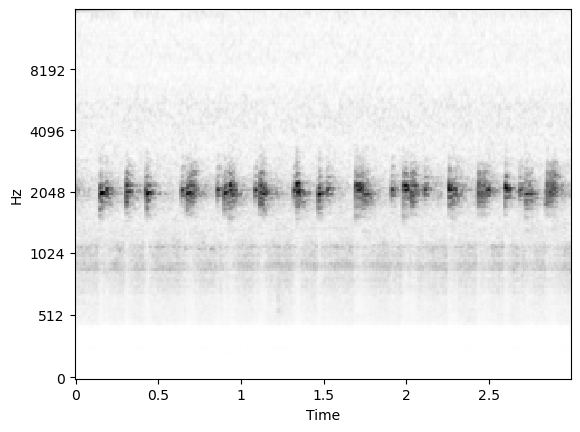

dataset name : anuraset
source uri   : audio/INCT20955/INCT20955_20200331_191500_23_26.wav
offset_s     : 0.00
rank         : 8
score        : 4.12


GridspecLayout(children=(Button(description='SPHSUR', layout=Layout(grid_area='widget001'), style=ButtonStyle(…


--------------------------------------------------------------------------------


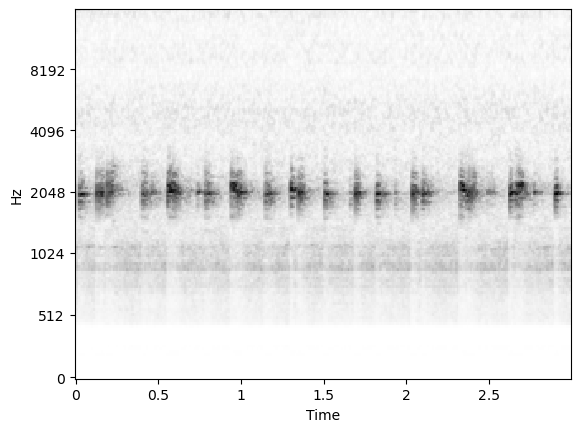

dataset name : anuraset
source uri   : audio/INCT20955/INCT20955_20200331_191500_29_32.wav
offset_s     : 0.00
rank         : 9
score        : 4.12


GridspecLayout(children=(Button(description='SPHSUR', layout=Layout(grid_area='widget001'), style=ButtonStyle(…


--------------------------------------------------------------------------------
Page 1 of 6


Button(description='Prev Page', style=ButtonStyle())

Button(description='Next Page', style=ButtonStyle())

In [12]:
#@title Display Results. { vertical-output: true }

display_results = embedding_display.EmbeddingDisplayGroup.from_search_results(
    results, db, sample_rate_hz=32000, frame_rate=100,
    audio_loader=audio_filepath_loader)
display_results.display(positive_labels=[target_label])

In [13]:
#@title Save data labels. { vertical-output: true }

prev_lbls, new_lbls = 0, 0
for lbl in display_results.harvest_labels(annotator_id):
  check = db.insert_label(lbl, skip_duplicates=True)
  new_lbls += check
  prev_lbls += (1 - check)
print('\nnew_lbls: ', new_lbls)
print('\nprev_lbls: ', prev_lbls)


new_lbls:  0

prev_lbls:  0


In [14]:
#@title Run inference with trained classifier. { vertical-output: true }

output_csv_filepath = ''  #@param {type:'string'}
logit_threshold = 1.0  #@param
# Set labels to a tuple of desired labels if you want to run inference on a
# subset of the labels.
labels = None  #@param

classifier.write_inference_csv(
    linear_classifier, db, output_csv_filepath, logit_threshold, labels=labels)


0it [00:00, ?it/s]CRITICAL:concurrent.futures:Exception in initializer:
Traceback (most recent call last):
  File "/home/Sedlar/miniforge3/envs/hoplite/lib/python3.10/concurrent/futures/thread.py", line 72, in _worker
    initializer(*initargs)
  File "/home/Sedlar/miniforge3/envs/hoplite/lib/python3.10/site-packages/perch_hoplite/agile/classifier.py", line 261, in csv_worker_initializer
    with epath.Path(state.csv_filepath).open('w') as f:
  File "/home/Sedlar/miniforge3/envs/hoplite/lib/python3.10/site-packages/etils/epath/gpath.py", line 257, in open
    gfile = self._backend.open(self._path_str, mode)
  File "/home/Sedlar/miniforge3/envs/hoplite/lib/python3.10/site-packages/etils/epath/backend.py", line 133, in open
    return open(path, mode, encoding=encoding)
IsADirectoryError: [Errno 21] Is a directory: '.'
3it [00:00, 97.98it/s]


BrokenThreadPool: A thread initializer failed, the thread pool is not usable anymore